In [ ]:
import torch  # type: ignore
import pyro  # type: ignore
import pyro.distributions as dist  # type: ignore
from pyro.optim import Adam  # type: ignore
from pyro.infer import SVI, Trace_ELBO  # type: ignore
from pyro.infer import MCMC, NUTS, HMC, RandomWalkKernel  # type: ignore
from torch.distributions import constraints  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import scipy  # type: ignore
import numpy as np  # type: ignore
import tqdm  # type: ignore
import pyro.poutine as poutine  # type: ignore
from statsmodels.graphics import tsaplots # type: ignore
import pandas as pd # type: ignore

plt.style.use('seaborn-v0_8-darkgrid')

### Example
Consider a model where $z=(z_\mu, z_\sigma)$ and $p(x \mid z) \sim \mathcal{N}(z_\mu, z_\sigma)$

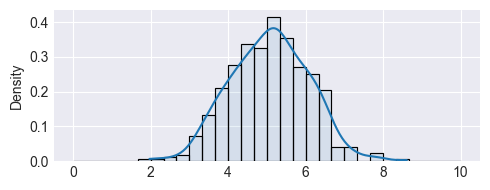

In [15]:
# Example data
true_mean=5
true_std=1
n_samples=500
x = true_mean + true_std*torch.randn(n_samples)# Generate n_samples random noisy data points with mean 5 and standard deviation 1

# Plotting the histogram of the data
plt.figure(figsize=(5, 2))  # Set the figure size
sns.histplot(x, binrange=(0,10), bins=30, kde=True, stat='density', alpha=0.1)  # Plot the histogram with KDE
plt.tight_layout()  # Adjust the layout to fit everything nicely
plt.show()  # Display the plot

# Markov Chain Monte Carlo (MCMC): 

Here we want to approximate the posterior distribution by samples:
$$z_n\sim p(z\mid x)$$
$$\hat p(z\mid x) = \frac{1}{N}\sum_{n=1}^N \delta(z_n-z)$$

In [16]:
def model(data):
    # Latent variable z with a Multivariate Normal prior
    z_mu = pyro.sample('z_mu', dist.Normal(0.0, 1.0))
    z_sigma = pyro.sample('z_sigma', dist.Gamma(2.0, 5.0))

    # Likelihood of the observed data
    with pyro.plate('data', len(data)):
        pyro.sample('obs', dist.Normal(z_mu, z_sigma), obs=data)

def log_true_posterior(z_mu, z_sigma, x, alpha=2, beta=5):
    return np.sum(-np.log(z_sigma)-0.5*np.square((x.numpy()-z_mu)/z_sigma))-0.5*np.square(z_mu) + (alpha-1)*np.log(z_sigma) - beta*z_sigma

In [17]:
def plot_solution(posterior_samples):
    z_mu = np.linspace(4.5, 5.5, 100)  # Range for z_mu
    z_sigma = np.linspace(0.5, 2, 100)  # Range for z_sigma

    Z_mu, Z_sigma = np.meshgrid(z_mu, z_sigma)

    log_p=np.squeeze(np.asarray([[log_true_posterior(_z_mu, _z_sigma, x) for _z_mu in z_mu] for _z_sigma in z_sigma]))
    log_p-=log_p.max()

    # Create the contour plot
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)  # Set the figure size

    plt.sca(ax[0])
    plt.contourf(Z_mu, Z_sigma, np.exp(log_p), levels=10, cmap='Blues')  # Plot the filled contour
    plt.xlabel(r'$z_\mu$')
    plt.ylabel(r'$z_\sigma$')
    plt.title('True Posterior')

    plt.sca(ax[1])
    xy = np.vstack([posterior_samples['z_mu'], posterior_samples['z_sigma']])
    z = scipy.stats.gaussian_kde(xy)(xy)
    plt.scatter(posterior_samples['z_mu'], posterior_samples['z_sigma'], s=2, c=z, cmap='Blues')
    plt.xlabel(r'$z_\mu$')
    plt.xlim(z_mu.min(), z_mu.max())
    plt.ylim(z_sigma.min(), z_sigma.max())
    plt.title('MCMC Posterior')

    # Show the plot
    plt.tight_layout()
    plt.show()


def plot_statistics(mcmc):
    posterior_samples=mcmc.get_samples()
    #plot autocorrelation function
    fig,ax=plt.subplots(1,2,figsize=(10,3))
    tsaplots.plot_acf(posterior_samples['z_mu'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax[0])
    tsaplots.plot_acf(posterior_samples['z_sigma'], zero=False, auto_ylims=False, bartlett_confint=False, lags=100, ax=ax[1])
    plt.tight_layout()
    plt.show()
    mcmc.summary()

# Hamiltonian Monte Carlo (HMC)

Sample: 100%|██████████| 3000/3000 [00:01, 1741.78it/s, step size=8.58e-01, acc. prob=0.917]


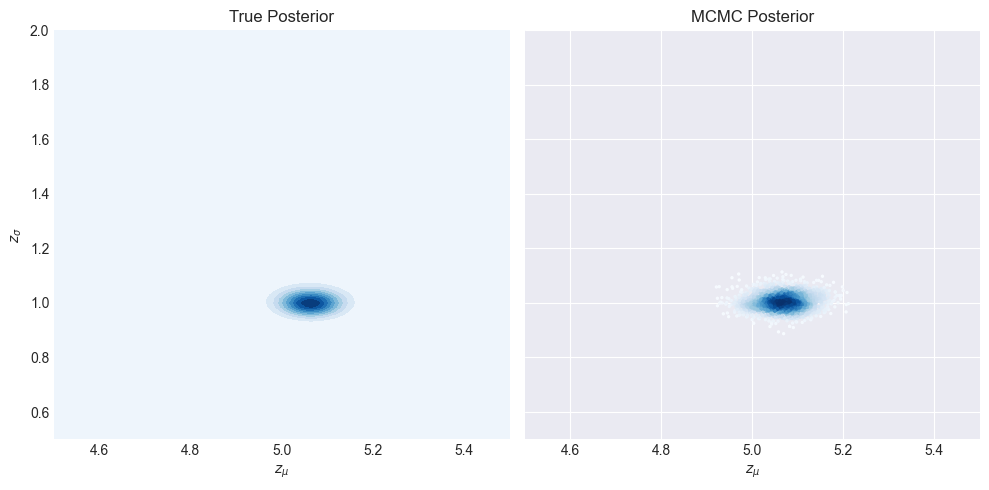

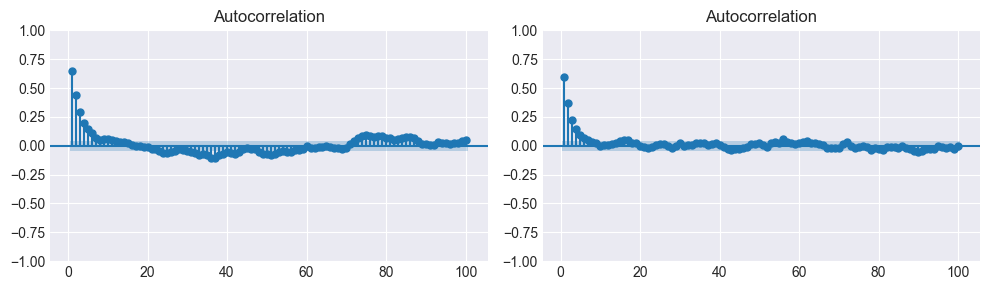


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      z_mu      5.07      0.05      5.07      4.99      5.15    364.52      1.01
   z_sigma      1.00      0.03      1.00      0.95      1.06    473.35      1.00

Number of divergences: 0


In [18]:
hmc_kernel = HMC(model, step_size=0.1, num_steps=1)
mcmc = MCMC(hmc_kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

plot_solution(posterior_samples)
plot_statistics(mcmc)

In [20]:
#g = sns.pairplot(pd.DataFrame({'mu':posterior_samples['z_mu'], 'std':posterior_samples['z_sigma']}))

# NUTS kernel

Sample: 100%|██████████| 2100/2100 [00:01, 1712.75it/s, step size=5.13e-02, acc. prob=0.829]


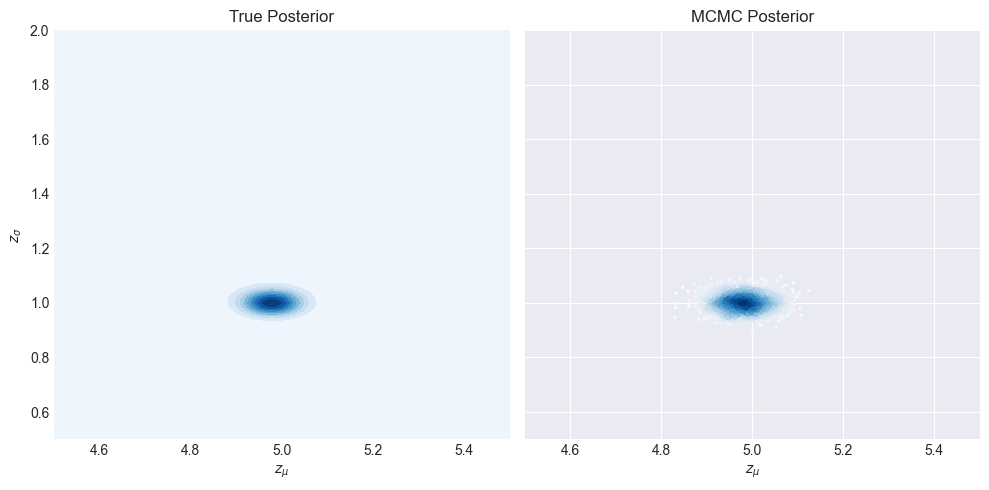

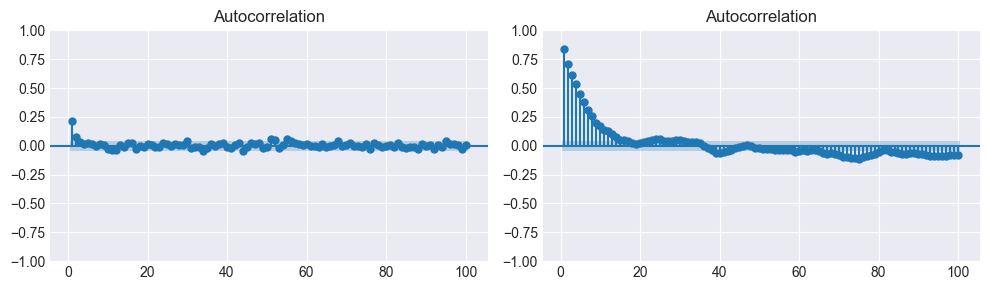


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      z_mu      4.98      0.04      4.98      4.91      5.05   1139.03      1.00
   z_sigma      1.00      0.03      1.00      0.95      1.06    168.09      1.00

Number of divergences: 0


In [10]:
nuts_kernel = NUTS(model, step_size=0.1, max_tree_depth=1)
mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=100)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

plot_solution(posterior_samples)
plot_statistics(mcmc)

# Random Walk Kernel

Sample: 100%|██████████| 20100/20100 [00:05, 3615.95it/s, step size=1.44e-01, acc. prob=0.109]


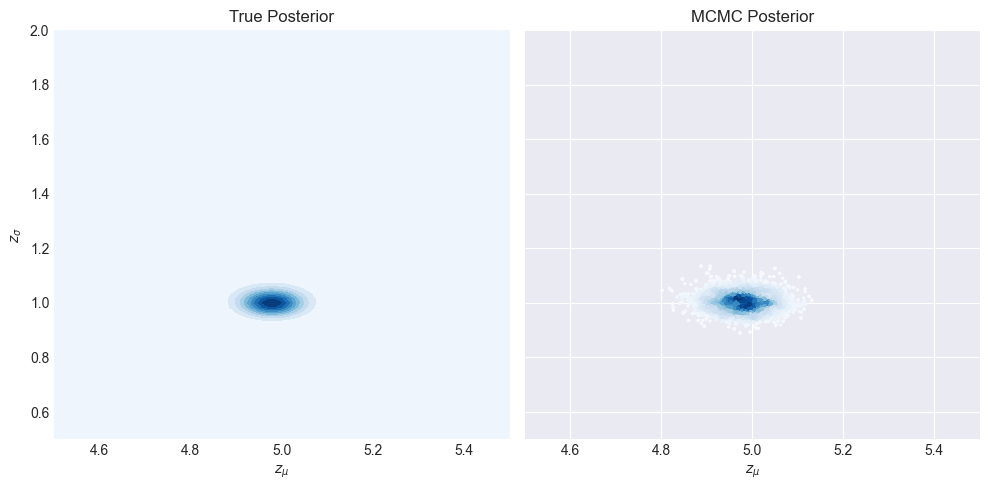

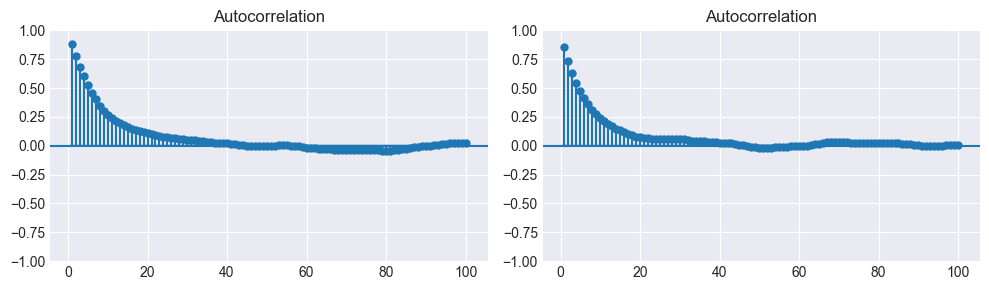


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      z_mu      4.98      0.05      4.98      4.90      5.05   1176.72      1.00
   z_sigma      1.00      0.03      1.00      0.95      1.05   1290.45      1.00



In [13]:
rw_kernel = RandomWalkKernel(model, init_step_size=.1, target_accept_prob=0.2)
mcmc = MCMC(rw_kernel, num_samples=2000, warmup_steps=100)
mcmc.run(x)
posterior_samples = mcmc.get_samples()

plot_solution(posterior_samples)
plot_statistics(mcmc)